In [27]:
from glob import glob
import os
import csv
from pathlib import Path
from enum import Enum
import json
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [28]:
DEPENDENCIES_BY_AUTOMATON = '../experiments/find-dependencies/by-automaton/'
DEPENDENCIES_BY_FORMULA = '../experiments/find-dependencies/by-formula/'

# Load Experiment Results

In [29]:
def get_benchmark_name(idx):
    path = "../tools/scripts/benchmarks/{}.txt".format(idx)
    with open(path, 'r') as file:
        name = file.readline().replace("\n", "")
    return name
print(get_benchmark_name(2))

EnemeyModule


In [30]:

def csv_to_dict_list(file_name):
    with open(file_name, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        dict_list = list(reader)
    return dict_list

general_benchmarks = csv_to_dict_list("../tools/scripts/benchmarks.csv")
def get_benchmark_group(name):
    for benchmark in general_benchmarks:
        if benchmark['benchmark_name'] == name:
            return benchmark['group_name']
    return None

In [31]:
class Status(Enum):
    ERROR = "Error"
    SUCCESS = "Success"
    NOT_FOUND = "Not Found"
    TIMEOUT = "Timeout"
    
    def __repr__(self):
        return str(self.value)
    
    def __str__(self):
        return str(self.value)

In [32]:
class Algorithm(Enum):
    AUTOMATON = "Automaton"
    FORMULA = "Formula"
    
    def __repr__(self):
        return str(self.value)
    
    def __str__(self):
        return str(self.value)

In [33]:
def get_all_benchmarks(path):
    hoa_files = glob(os.path.join(path, "*.hoa"))
    names = [
        Path(f).stem
        for f in hoa_files
    ]
    return names

print("Total benchmark of finding dependencies by automaton" , len(get_all_benchmarks(DEPENDENCIES_BY_AUTOMATON)))
print("Total benchmark of finding dependencies by formula" , len(get_all_benchmarks(DEPENDENCIES_BY_FORMULA)))

Total benchmark of finding dependencies by automaton 564
Total benchmark of finding dependencies by formula 564


In [34]:
def benchmark_loader(algorithm: Algorithm, path: str):
    def load_benchmark(idx: str):
        base = {
            'id': int(idx),
            'Name': get_benchmark_name(idx),
        }

        hoa_path = os.path.join(path, idx + ".hoa")
        json_path = os.path.join(path, idx + ".json")

        if not os.path.exists(hoa_path):
            return {
                **base,
                'Status': Status.NOT_FOUND
            }

        with open(hoa_path, 'r') as f:
            hoa_content = f.readlines()
            if 'DUE TO TIME LIMIT' in "\n".join(hoa_content):
                return {
                    **base,
                    'Status': Status.TIMEOUT,
                }

        if not os.path.exists(json_path):
            return {
                **base,
                'Status': Status.ERROR,
                'Error': "\n".join(hoa_content)
            }

        with open(json_path, 'r') as f:
            content = "\r\n".join(f.readlines())
            try:
                benchmark_json = json.loads(content)
            except Exception as e:
                return {
                    **base,
                    'Status': Status.ERROR,
                    'Error': content
                }
        
        if benchmark_json['dependency']["dependency_approach"] != algorithm.value.lower():
            raise Exception("Algorithm mismatch")

        is_completed = benchmark_json['is_completed']
        total_time = benchmark_json['total_time']
        output_vars = benchmark_json['output_vars']
        input_vars = benchmark_json['input_vars']
        is_automaton_built = benchmark_json['automaton']['is_built']

        base = {
            **base,
            'Is Completed': is_completed,
            'Total Duration': total_time,
            'Total Output Vars': len(output_vars),
            'Total Input Vars': len(input_vars),
            'Output Vars': output_vars,
            'Input Vars': input_vars,
            'Is Automaton Built': is_automaton_built,
        }

        if algorithm == Algorithm.AUTOMATON:
            automaton_build_duration = benchmark_json['automaton'].get('build_duration', None)
            total_states = benchmark_json['automaton'].get('total_states', None) if is_automaton_built else None
            total_edges = benchmark_json['automaton'].get('total_edges', None) if is_automaton_built else None
            base = {
                **base,
                'Total States': total_states,
                'Total Edges': total_edges,
                'Is Automaton Built': is_automaton_built,
                'Automaton Build Duration': automaton_build_duration,
            }

        if algorithm == Algorithm.AUTOMATON:
            total_pair_states = benchmark_json['dependency'].get('total_pair_state',None)
            search_pair_states_duration = benchmark_json['dependency'].get('search_pair_state_duration',None)
        else:
            total_pair_states, search_pair_states_duration = None, None
        
        dependent_vars = []
        independent_vars = []
        
        for var_description in benchmark_json["dependency"]['tested_dependencies']:
            if var_description['is_dependent']:
                dependent_vars.append(var_description['name'])
            else:
                independent_vars.append(var_description['name'])


        if not is_completed:
            error = None
            status = Status.TIMEOUT
            if "bad_alloc" in "\n".join(hoa_content):
                status = Status.ERROR
                error = 'Out of Memory'
            elif "Error occurred" in "\n".join(hoa_content):
                status = Status.ERROR
                error = hoa_content[1:]

            return {
                **base,
                'Status': status,
                'Error': error,
                'Dependent Vars': dependent_vars,
                'Independent Vars': independent_vars,
            }

        return {
            **base,
            'Status': Status.SUCCESS,
            'Total Dependents': len(dependent_vars),
            'Dependency Ratio': len(dependent_vars) / len(output_vars),

            'Total Pair States': total_pair_states,
            'Search Pair States Duration': search_pair_states_duration,

            'Dependent Vars': dependent_vars,
            'Independent Vars': independent_vars,
        }

    return load_benchmark

## Load benchmarks by Automaton

In [35]:
by_automaton_loader = benchmark_loader(Algorithm.AUTOMATON, DEPENDENCIES_BY_AUTOMATON)
by_automaton_df = pd.DataFrame([by_automaton_loader(name) for name in get_all_benchmarks(DEPENDENCIES_BY_AUTOMATON)])
by_automaton_df.set_index("id", inplace=True)
by_automaton_df

,Name,Is Completed,Total Duration,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Is Automaton Built,Total States,Total Edges,Automaton Build Duration,Status,Total Dependents,Dependency Ratio,Total Pair States,Search Pair States Duration,Dependent Vars,Independent Vars,Error
id,,,,,,,,,,,,,,,,,,,
208,CheckCoffeMachine_3461125b,True,19,4,4,"[u0cm29ctrl0f1dturn2off1b, u0cm29ctrl0f1dmake2...","[p0b0cm29finished, p0b0cm29busy, p0b0cm29stand...",True,10.0,34.0,18.0,Success,1.0,0.250000,24.0,0.0,[u0cm29ctrl0cm29ctrl],"[u0cm29ctrl0f1dturn2on1b, u0cm29ctrl0f1dmake2c...",NaN
234,CoffeMachine_974f4a68,True,42,4,6,"[u02c2m29ctrl0f1d2c2m29turn2off1b, u02c2m29ctr...","[p0p0standby02c2m29intend, p0p0ready02c2m29int...",True,20.0,85.0,37.0,Success,1.0,0.250000,122.0,0.0,[u02c2m29ctrl02c2m29ctrl],"[u02c2m29ctrl0f1d2c2m29turn2on1b, u02c2m29ctrl...",NaN
552,ltl2dba_beta,True,13,1,4,[acc],"[q_0, q_1, p_0, p_1]",True,19.0,74.0,12.0,Success,0.0,0.000000,120.0,0.0,[],[acc],NaN
546,ltl2dba24,True,5,1,1,[acc],[p],True,4.0,8.0,5.0,Success,0.0,0.000000,5.0,0.0,[],[acc],NaN
220,Timer_a50cadd7,True,7,4,1,"[u0system29start2new2timer0f1dhour251b, u0syst...",[p0b0timeout],True,2.0,4.0,6.0,Success,1.0,0.250000,2.0,0.0,[u0system29start2new2timer0system29start2new2t...,"[u0system29start2new2timer0f1dmin25231b, u0sys...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,TwoCountersInRangeA3,True,3606,8,11,"[u0selected0f1dtoggle0selected1b, u0selected0s...","[p0p0second0selected, p0p0in2range0f1dincremen...",True,6.0,13.0,3602.0,Success,3.0,0.375000,16.0,0.0,"[u0first2counter0first2counter, u0second2count...","[u0first2counter0f1ddecrement0first2counter1b,...",NaN
239,AllLights_63831f8c,True,46957,8,12,[u02roomlight29light0f1d2roomlight29turn2off1b...,"[p0p0bright0outside29brightness, p0b0bed29occu...",True,112.0,2283.0,44010.0,Success,2.0,0.250000,1422.0,76.0,[u02timer29start2new2timer02timer29start2new2t...,[u02timer29start2new2timer0f1d2timer29min25231...,NaN
205,Lights_3461125b,True,51,4,6,"[u0room29light0f1dturn2off1b, u0room29light0f1...","[p0b0room29light29off, p0b0room29light29on, p0...",True,11.0,31.0,50.0,Success,1.0,0.250000,52.0,0.0,[u0room29light0room29light],"[u0room29light0f1dturn2on1b, u0room29light0f1d...",NaN


### Analysing Errors

In [36]:
by_automaton_df[by_automaton_df["Status"] == Status.ERROR][["Name", "Status", "Error"]]

,Name,Status,Error
id,,,
301,AllShades_66f450a4,Error,Out of Memory


In [37]:
by_automaton_df[(by_automaton_df["Status"] == Status.TIMEOUT)]

,Name,Is Completed,Total Duration,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Is Automaton Built,Total States,Total Edges,Automaton Build Duration,Status,Total Dependents,Dependency Ratio,Total Pair States,Search Pair States Duration,Dependent Vars,Independent Vars,Error
id,,,,,,,,,,,,,,,,,,,
80,TwoCountersDisButA8,False,3599996,13,14,"[u0window0f1denable2button0up1b, u0window0f1de...","[p0p0second0selected, p0p0in2range0f1dincremen...",False,NaN,NaN,NaN,Timeout,NaN,NaN,NaN,NaN,[],[],None
142,amba_gr+_6,False,3599995,26,15,"[req_ready, stateg10_5, stateg10_4, stateg10_3...","[hburst1, hburst0, hlock5, hbusreq5, hlock4, h...",False,NaN,NaN,NaN,Timeout,NaN,NaN,NaN,NaN,[],[],None
56,TwoCountersDisButA9,False,3599995,13,14,"[u0window0f1denable2button0up1b, u0window0f1de...","[p0p0second0selected, p0p0in2range0f1dincremen...",False,NaN,NaN,NaN,Timeout,NaN,NaN,NaN,NaN,[],[],None
143,amba_gr+_11,False,3599991,37,25,"[req_ready, stateg10_10, stateg10_9, stateg10_...","[hburst1, hburst0, hlock10, hbusreq10, hlock9,...",False,NaN,NaN,NaN,Timeout,NaN,NaN,NaN,NaN,[],[],None
221,Full_f1477cc5,False,3599996,30,36,"[u0music29ctrl0f1dplay0f1doverture1b1b, u0musi...",[p0p0gt0outside29temperature0room29temperature...,False,NaN,NaN,NaN,Timeout,NaN,NaN,NaN,NaN,[],[],None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,Morning2_407db2cc,False,3599995,10,18,[u02shades29ctrl0f1d2shades29move2to0f1d2shade...,"[p0p02time29between02time29pm702time29pm8, p0p...",False,NaN,NaN,NaN,Timeout,NaN,NaN,NaN,NaN,[],[],None
204,Morning_c92eb242,False,3599996,15,14,"[u0tv29ctrl0f1dturn2on1b, u0tv29ctrl0tv29ctrl,...","[p0p02time29between02time29pm702time29pm8, p0p...",False,NaN,NaN,NaN,Timeout,NaN,NaN,NaN,NaN,[],[],None
238,Morning2_63831f8c,False,3599996,10,21,[u02shades29ctrl0f1d2shades29move2to0f1d2shade...,[p0p02time29between0p1db02time29pm71b02time29p...,False,NaN,NaN,NaN,Timeout,NaN,NaN,NaN,NaN,[],[],None


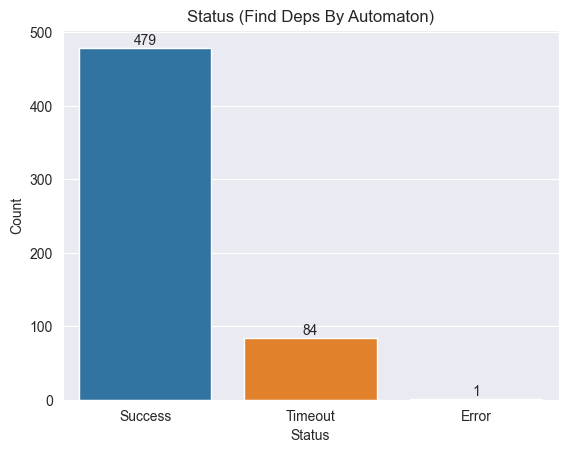

In [38]:
tmp_df = by_automaton_df.copy()
tmp_df["Status"] = tmp_df["Status"].astype(str)
ax = sns.countplot(data=tmp_df, x="Status")
ax.bar_label(ax.containers[0])
plt.title('Status (Find Deps By Automaton)')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

## Load benchmarks by Formula

In [39]:
by_formula_loader = benchmark_loader(Algorithm.FORMULA, DEPENDENCIES_BY_FORMULA)
by_formula_df = pd.DataFrame([by_formula_loader(name) for name in get_all_benchmarks(DEPENDENCIES_BY_FORMULA)])
by_formula_df.set_index("id", inplace=True)
by_formula_df

,Name,Is Completed,Total Duration,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Is Automaton Built,Status,Total Dependents,Dependency Ratio,Total Pair States,Search Pair States Duration,Dependent Vars,Independent Vars,Error
id,,,,,,,,,,,,,,,,
208,CheckCoffeMachine_3461125b,True,12113.0,4.0,4.0,"[u0cm29ctrl0f1dturn2off1b, u0cm29ctrl0f1dmake2...","[p0b0cm29finished, p0b0cm29busy, p0b0cm29stand...",True,Success,1.0,0.250000,NaN,NaN,[u0cm29ctrl0cm29ctrl],"[u0cm29ctrl0f1dturn2on1b, u0cm29ctrl0f1dmake2c...",NaN
234,CoffeMachine_974f4a68,False,3599996.0,4.0,6.0,"[u02c2m29ctrl0f1d2c2m29turn2off1b, u02c2m29ctr...","[p0p0standby02c2m29intend, p0p0ready02c2m29int...",True,Timeout,NaN,NaN,NaN,NaN,[u02c2m29ctrl02c2m29ctrl],"[u02c2m29ctrl0f1d2c2m29turn2on1b, u02c2m29ctrl...",None
552,ltl2dba_beta,False,3599997.0,1.0,4.0,[acc],"[q_0, q_1, p_0, p_1]",True,Timeout,NaN,NaN,NaN,NaN,[],[],None
546,ltl2dba24,True,15.0,1.0,1.0,[acc],[p],True,Success,0.0,0.000000,NaN,NaN,[],[acc],NaN
220,Timer_a50cadd7,True,51.0,4.0,1.0,"[u0system29start2new2timer0f1dhour251b, u0syst...",[p0b0timeout],True,Success,1.0,0.250000,NaN,NaN,[u0system29start2new2timer0system29start2new2t...,"[u0system29start2new2timer0f1dmin25231b, u0sys...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,TwoCountersInRangeA3,False,3599996.0,8.0,11.0,"[u0selected0f1dtoggle0selected1b, u0selected0s...","[p0p0second0selected, p0p0in2range0f1dincremen...",True,Timeout,NaN,NaN,NaN,NaN,[],[],None
239,AllLights_63831f8c,False,3599996.0,8.0,12.0,[u02roomlight29light0f1d2roomlight29turn2off1b...,"[p0p0bright0outside29brightness, p0b0bed29occu...",True,Timeout,NaN,NaN,NaN,NaN,[],[],None
205,Lights_3461125b,False,3600003.0,4.0,6.0,"[u0room29light0f1dturn2off1b, u0room29light0f1...","[p0b0room29light29off, p0b0room29light29on, p0...",True,Timeout,NaN,NaN,NaN,NaN,[u0room29light0room29light],[],None


In [40]:
by_formula_df[by_formula_df["Status"] == Status.ERROR]

,Name,Is Completed,Total Duration,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Is Automaton Built,Status,Total Dependents,Dependency Ratio,Total Pair States,Search Pair States Duration,Dependent Vars,Independent Vars,Error
id,,,,,,,,,,,,,,,,
427,Demo1_06e9cad4_3,False,199930.0,3.0,9.0,"[u02heating29ctrl0f1d2heating29turn2off1b, u02...","[p0p0lt0f1dten2degree1b02room29temperature, p0...",True,Error,NaN,NaN,NaN,NaN,[u02heating29ctrl02heating29ctrl],[],Out of Memory
223,Lights_06e9cad4,False,219045.0,4.0,8.0,[u02roomlight29light0f1d2roomlight29turn2off1b...,"[p0b02room292room29empty, p0b02room29bed29occu...",True,Error,NaN,NaN,NaN,NaN,[u02roomlight29light02roomlight29light],[],Out of Memory
380,Full_f1477cc5_2,False,334184.0,5.0,6.0,"[u0music29ctrl0f1dplay0f1doverture1b1b, u0musi...",[p0p0gt0outside29temperature0room29temperature...,True,Error,NaN,NaN,NaN,NaN,[u0room29heating29ctrl0room29heating29ctrl],[],Out of Memory
430,Demo1_06e9cad4_4,False,139476.0,4.0,8.0,"[u02c2m29ctrl0f1d2c2m29turn2off1b, u02c2m29ctr...","[p0b02c2m29finished, p0b02c2m29busy, p0b02c2m2...",True,Error,NaN,NaN,NaN,NaN,[u02c2m29ctrl02c2m29ctrl],[],Out of Memory
3,KitchenTimerV4,False,2063060.0,6.0,4.0,"[u0time0f1dcountup0time0dt1b, u0time0f1dcountd...","[p0p0eq0time0f1dzero1b, p0b0btn2start2stop, p0...",True,Error,NaN,NaN,NaN,NaN,"[u0time0time, u0time0f1dzero1b]",[],Out of Memory
386,Demo1_2c5b09da_5,False,1864639.0,4.0,9.0,[u02roomlight29light0f1d2roomlight29turn2off1b...,"[p0b02roomlight29off, p0b02roomlight29on, p0b0...",True,Error,NaN,NaN,NaN,NaN,[u02roomlight29light02roomlight29light],[],Out of Memory
47,KitchenTimerV3,False,431126.0,6.0,4.0,"[u0time0f1dcountup0time0dt1b, u0time0f1dcountd...","[p0p0eq0time0f1dzero1b, p0b0btn2start2stop, p0...",True,Error,NaN,NaN,NaN,NaN,"[u0time0time, u0time0f1dzero1b]",[],Out of Memory
486,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Error,NaN,NaN,NaN,NaN,NaN,NaN,Runtime error: Too many acceptance sets used. ...
487,08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Error,NaN,NaN,NaN,NaN,NaN,NaN,Runtime error: Too many acceptance sets used. ...


In [41]:
by_formula_df[by_formula_df["Status"] == Status.TIMEOUT]

,Name,Is Completed,Total Duration,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Is Automaton Built,Status,Total Dependents,Dependency Ratio,Total Pair States,Search Pair States Duration,Dependent Vars,Independent Vars,Error
id,,,,,,,,,,,,,,,,
234,CoffeMachine_974f4a68,False,3599996.0,4.0,6.0,"[u02c2m29ctrl0f1d2c2m29turn2off1b, u02c2m29ctr...","[p0p0standby02c2m29intend, p0p0ready02c2m29int...",True,Timeout,NaN,NaN,NaN,NaN,[u02c2m29ctrl02c2m29ctrl],"[u02c2m29ctrl0f1d2c2m29turn2on1b, u02c2m29ctrl...",None
552,ltl2dba_beta,False,3599997.0,1.0,4.0,[acc],"[q_0, q_1, p_0, p_1]",True,Timeout,NaN,NaN,NaN,NaN,[],[],None
80,TwoCountersDisButA8,False,3599996.0,13.0,14.0,"[u0window0f1denable2button0up1b, u0window0f1de...","[p0p0second0selected, p0p0in2range0f1dincremen...",False,Timeout,NaN,NaN,NaN,NaN,[],[],None
142,amba_gr+_6,False,3599995.0,26.0,15.0,"[req_ready, stateg10_5, stateg10_4, stateg10_3...","[hburst1, hburst0, hlock5, hbusreq5, hlock4, h...",False,Timeout,NaN,NaN,NaN,NaN,[],[],None
156,mux,False,3599855.0,1.0,14.0,[out],"[in_0, in_1, in_2, in_3, in_4, in_5, in_6, in_...",True,Timeout,NaN,NaN,NaN,NaN,[],[],None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,Cockpitboard,False,3599996.0,19.0,6.0,"[u0ycoord0f1dinc2coord0ycoord1b, u0ycoord0ycoo...",[p0p0hitcoord0xcoord0ycoord0f1dgetenemyradius0...,True,Timeout,NaN,NaN,NaN,NaN,[],[],None
173,lilydemo06,False,3600006.0,1.0,3.0,[grant],"[go, cancel, req]",True,Timeout,NaN,NaN,NaN,NaN,[],[],None
99,TwoCountersInRangeA3,False,3599996.0,8.0,11.0,"[u0selected0f1dtoggle0selected1b, u0selected0s...","[p0p0second0selected, p0p0in2range0f1dincremen...",True,Timeout,NaN,NaN,NaN,NaN,[],[],None


### Analysing by Status

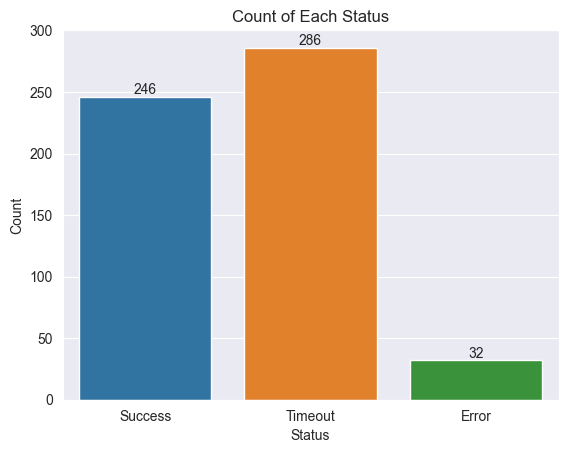

In [42]:
tmp_df = by_formula_df.copy()
tmp_df["Status"] = tmp_df["Status"].astype(str)
ax = sns.countplot(data=tmp_df, x="Status")
ax.bar_label(ax.containers[0])
plt.title('Count of Each Status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

# By Formula vs By Automaton

In [43]:
find_deps_df = pd.merge(
    by_automaton_df,
    by_formula_df,
    on=["id", "Name"],
    suffixes=(" (automaton)", " (formula)")
)
find_deps_df

,Name,Is Completed (automaton),Total Duration (automaton),Total Output Vars (automaton),Total Input Vars (automaton),Output Vars (automaton),Input Vars (automaton),Is Automaton Built (automaton),Total States,Total Edges,...,Input Vars (formula),Is Automaton Built (formula),Status (formula),Total Dependents (formula),Dependency Ratio (formula),Total Pair States (formula),Search Pair States Duration (formula),Dependent Vars (formula),Independent Vars (formula),Error (formula)
id,,,,,,,,,,,,,,,,,,,,,
208,CheckCoffeMachine_3461125b,True,19,4,4,"[u0cm29ctrl0f1dturn2off1b, u0cm29ctrl0f1dmake2...","[p0b0cm29finished, p0b0cm29busy, p0b0cm29stand...",True,10.0,34.0,...,"[p0b0cm29finished, p0b0cm29busy, p0b0cm29stand...",True,Success,1.0,0.250000,NaN,NaN,[u0cm29ctrl0cm29ctrl],"[u0cm29ctrl0f1dturn2on1b, u0cm29ctrl0f1dmake2c...",NaN
234,CoffeMachine_974f4a68,True,42,4,6,"[u02c2m29ctrl0f1d2c2m29turn2off1b, u02c2m29ctr...","[p0p0standby02c2m29intend, p0p0ready02c2m29int...",True,20.0,85.0,...,"[p0p0standby02c2m29intend, p0p0ready02c2m29int...",True,Timeout,NaN,NaN,NaN,NaN,[u02c2m29ctrl02c2m29ctrl],"[u02c2m29ctrl0f1d2c2m29turn2on1b, u02c2m29ctrl...",None
552,ltl2dba_beta,True,13,1,4,[acc],"[q_0, q_1, p_0, p_1]",True,19.0,74.0,...,"[q_0, q_1, p_0, p_1]",True,Timeout,NaN,NaN,NaN,NaN,[],[],None
546,ltl2dba24,True,5,1,1,[acc],[p],True,4.0,8.0,...,[p],True,Success,0.0,0.000000,NaN,NaN,[],[acc],NaN
220,Timer_a50cadd7,True,7,4,1,"[u0system29start2new2timer0f1dhour251b, u0syst...",[p0b0timeout],True,2.0,4.0,...,[p0b0timeout],True,Success,1.0,0.250000,NaN,NaN,[u0system29start2new2timer0system29start2new2t...,"[u0system29start2new2timer0f1dmin25231b, u0sys...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,TwoCountersInRangeA3,True,3606,8,11,"[u0selected0f1dtoggle0selected1b, u0selected0s...","[p0p0second0selected, p0p0in2range0f1dincremen...",True,6.0,13.0,...,"[p0p0second0selected, p0p0in2range0f1dincremen...",True,Timeout,NaN,NaN,NaN,NaN,[],[],None
239,AllLights_63831f8c,True,46957,8,12,[u02roomlight29light0f1d2roomlight29turn2off1b...,"[p0p0bright0outside29brightness, p0b0bed29occu...",True,112.0,2283.0,...,"[p0p0bright0outside29brightness, p0b0bed29occu...",True,Timeout,NaN,NaN,NaN,NaN,[],[],None
205,Lights_3461125b,True,51,4,6,"[u0room29light0f1dturn2off1b, u0room29light0f1...","[p0b0room29light29off, p0b0room29light29on, p0...",True,11.0,31.0,...,"[p0b0room29light29off, p0b0room29light29on, p0...",True,Timeout,NaN,NaN,NaN,NaN,[u0room29light0room29light],[],None


### Sanity Check - Same dependent variables

In [44]:
find_deps_df[(find_deps_df["Dependent Vars (automaton)"] != find_deps_df["Dependent Vars (formula)"]) & (find_deps_df["Status (formula)"] == True)]

,Name,Is Completed (automaton),Total Duration (automaton),Total Output Vars (automaton),Total Input Vars (automaton),Output Vars (automaton),Input Vars (automaton),Is Automaton Built (automaton),Total States,Total Edges,...,Input Vars (formula),Is Automaton Built (formula),Status (formula),Total Dependents (formula),Dependency Ratio (formula),Total Pair States (formula),Search Pair States Duration (formula),Dependent Vars (formula),Independent Vars (formula),Error (formula)
id,,,,,,,,,,,,,,,,,,,,,


### Sanity Check - Automaton Could be constructed in formula same as automaton

In [45]:
mask = find_deps_df.apply(lambda row: row['Is Automaton Built (automaton)'] == row['Is Automaton Built (formula)'] or (pd.isnull(row['Is Automaton Built (automaton)']) and pd.isnull(row['Is Automaton Built (formula)'])), axis=1)
find_deps_df[~mask][["Name","Is Completed (automaton)","Is Completed (formula)","Is Automaton Built (automaton)","Is Automaton Built (formula)"]]

,Name,Is Completed (automaton),Is Completed (formula),Is Automaton Built (automaton),Is Automaton Built (formula)
id,,,,,
486,12,False,NaN,False,NaN
487,08,False,NaN,False,NaN
491,10,False,NaN,False,NaN
485,13,False,NaN,False,NaN
484,05,False,NaN,False,NaN
490,06,False,NaN,False,NaN
481,03,True,NaN,True,NaN
285,Lights2Min_9cbf2546,True,NaN,True,NaN
483,09,False,NaN,False,NaN


### Sanity Check - Find Deps By Automaton and DepSynt has same dependent variables

In [78]:
by_find_deps = by_automaton_df
by_synt = pd.read_csv('./DepSynt.csv')

X = pd.merge(by_find_deps, by_synt, on='id', how='inner', suffixes=(' (Find Deps)', ' (DepSynt)'))
X = X[[
    'id',
    'Total Dependents', 'Total Dependent Variables',
    'Find Dependency Completed',
    'Is Completed (Find Deps)', 'Is Completed (DepSynt)',
    'Total Duration (Find Deps)','Total Duration (DepSynt)',
    'Is Automaton Built (Find Deps)','Is Automaton Built (DepSynt)',
    'Automaton Build Duration (Find Deps)', 'Automaton Build Duration (DepSynt)',
]]
X.rename(columns={'Total Dependents': 'Total Dependents (Find Deps)', 'Total Dependent Variables': 'Total Dependents (DepSynt)', 'Find Dependency Completed': 'Find Dependency Completed (DepSynt)'}, inplace=True)
X['Total Dependents (Find Deps)']  =X['Total Dependents (Find Deps)'].fillna(0)
X['Total Dependents (DepSynt)']  =X['Total Dependents (DepSynt)'].fillna(0)
X[X['Total Dependents (Find Deps)'] != X['Total Dependents (DepSynt)']]

,id,Total Dependents (Find Deps),Total Dependents (DepSynt),Find Dependency Completed (DepSynt),Is Completed (Find Deps),Is Completed (DepSynt),Total Duration (Find Deps),Total Duration (DepSynt),Is Automaton Built (Find Deps),Is Automaton Built (DepSynt),Automaton Build Duration (Find Deps),Automaton Build Duration (DepSynt)
5,80,0.0,4.0,True,False,True,3599996,44669.0,False,True,NaN,13518.0
31,56,0.0,4.0,True,False,True,3599995,90678.0,False,True,NaN,19616.0
53,40,0.0,2.0,False,False,False,3599995,899993.0,False,True,NaN,965.0
61,343,0.0,10.0,True,False,False,3599995,899991.0,False,True,NaN,16.0
62,394,0.0,8.0,True,False,False,3599994,899991.0,False,True,NaN,8.0
65,395,0.0,8.0,True,False,False,3599995,899991.0,False,True,NaN,9.0
68,356,2.0,1.0,False,True,False,60448,899992.0,True,True,57540.0,7701.0
70,418,0.0,6.0,True,False,True,3599996,396272.0,False,True,NaN,394636.0
96,79,0.0,4.0,True,False,True,3599997,450076.0,False,True,NaN,45671.0
129,227,0.0,10.0,True,False,False,3599996,899987.0,False,True,NaN,17.0
